Project Three, Question Two

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

In [2]:
train = pd.read_csv(r"C:\Users\ROG\Desktop\Worklife\Data\MLBootcamp\Project3\Part2\Data\train_data.csv")
test = pd.read_csv(r"C:\Users\ROG\Desktop\Worklife\Data\MLBootcamp\Project3\Part2\Data\test_data.csv")
titles = pd.read_csv(r"C:\Users\ROG\Desktop\Worklife\Data\MLBootcamp\Project3\Part2\Data\title_brand.csv")

C:\Users\ROG\AppData\Local\Temp\ipykernel_19800\596588134.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(r"C:\Users\ROG\Desktop\Worklife\Data\MLBootcamp\Project3\Part2\Data\train_data.csv")


In [3]:
train.isna().sum()

overall                0
vote              647476
verified               0
reviewTime             0
reviewerID             0
asin                   0
style             348331
reviewerName         227
reviewText             0
summary               76
unixReviewTime         0
dtype: int64

In [4]:
test.isna().sum()

vote              15067
verified              0
reviewTime            0
reviewerID            0
asin                  0
style              8496
reviewerName          4
reviewText            0
summary               2
unixReviewTime        0
dtype: int64

We need to handle the Nan values.

"vote" nans are where there has been no helpful vote for the review, therefore we will fill the nan values in this column with 0s.

"reviewerName" is not that important in our sentiment analysis and the number is limited so we will get rid of their rows.

"summary" is pretty important and because of the number of nans compared to the whole dataset, we will drop the rows that don't have any value in this column.

"style" won't affect the result much (or at least shouldn't), and thence we will drop the respective column.

We also have a time column so probably there is no need for UnixTime.

In [5]:
train.drop(columns=['style', 'unixReviewTime'], inplace=True)
test.drop(columns=['style', 'unixReviewTime'], inplace=True)

In [6]:
train = train[train['reviewerName'].notna()]
test = test[test['reviewerName'].notna()]

In [7]:
train = train[train['summary'].notna()]
test = test[test['summary'].notna()]

In [8]:
train["vote"].fillna(0, inplace=True)
test["vote"].fillna(0, inplace=True)

In [9]:
train.isna().sum(), train.shape

(overall         0
 vote            0
 verified        0
 reviewTime      0
 reviewerID      0
 asin            0
 reviewerName    0
 reviewText      0
 summary         0
 dtype: int64,
 (838641, 9))

In [10]:
test.isna().sum(), test.shape

(vote            0
 verified        0
 reviewTime      0
 reviewerID      0
 asin            0
 reviewerName    0
 reviewText      0
 summary         0
 dtype: int64,
 (19994, 8))

Now that we have handled nans, we can check our datatypes and other things:

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 838641 entries, 0 to 838943
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   overall       838641 non-null  int64 
 1   vote          838641 non-null  object
 2   verified      838641 non-null  bool  
 3   reviewTime    838641 non-null  object
 4   reviewerID    838641 non-null  object
 5   asin          838641 non-null  object
 6   reviewerName  838641 non-null  object
 7   reviewText    838641 non-null  object
 8   summary       838641 non-null  object
dtypes: bool(1), int64(1), object(7)
memory usage: 58.4+ MB


In [12]:
train

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary
0,2,0,False,2016-11-11,A2OSUEZJIN7BI,0511189877,Chris,I have an older URC-WR7 remote and thought thi...,Cannot Learn
1,5,0,True,2016-06-06,A2NETQRG6JHIG7,0511189877,Qrysta White,First time I've EVER had a remote that needed ...,zero programming needed! Miracle!?
2,4,0,True,2016-03-10,A12JHGROAX49G7,0511189877,Linwood,Got them and only 2 of them worked. company ca...,Works Good and programs easy.
3,5,0,True,2016-01-14,A1KV65E2TMMG6F,0511189877,Dane Williams,I got tired of the remote being on the wrong s...,Same as TWC remote
4,5,0,True,2016-10-20,A280POPEWI0NSA,0594459451,Kristina H.,After purchasing cheap cords from another webs...,Good Quality Cord
...,...,...,...,...,...,...,...,...,...
838939,5,0,True,2017-07-25,A1OOVLE2KZ6KGA,B01HJCN1EI,Puddzee,These are my favorite charging cords for a few...,Worth the price.
838940,1,0,True,2017-04-04,A77K1B31UAQ29,B01HJCN1EI,addictedtoreading,"Update....after 2 months of gentle use, cable ...",UPDATE...BREAKS AND SLOW CHARGING
838941,3,0,True,2017-07-08,A2SVXUVUAWUDK2,B01HJH42KU,Andrew,These are okay. The connection becomes very if...,Hope this makes sense. You'd understand if you...
838942,5,2.0,True,2016-12-01,A2HUZO7MQAY5I2,B01HJH40WU,michael clontz,"Ok here is an odd thing that happened to me, I...",Not the correct product as linked in the sale.


In [13]:
train[['verified']] = train[['verified']].replace([False, True], [0, 1])
test[['verified']] = test[['verified']].replace([False, True], [0, 1])

In [17]:
train['vote'] = pd.to_numeric(train['vote'], errors='coerce').fillna(0)
test['vote'] = pd.to_numeric(test['vote'], errors='coerce').fillna(0)

In [18]:
train["reviewTime"] = pd.to_datetime(train["reviewTime"])
test["reviewTime"] = pd.to_datetime(test["reviewTime"])

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 838641 entries, 0 to 838943
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   overall       838641 non-null  int64         
 1   vote          838641 non-null  float64       
 2   verified      838641 non-null  int64         
 3   reviewTime    838641 non-null  datetime64[ns]
 4   reviewerID    838641 non-null  object        
 5   asin          838641 non-null  object        
 6   reviewerName  838641 non-null  object        
 7   reviewText    838641 non-null  object        
 8   summary       838641 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 64.0+ MB


In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19994 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   vote          19994 non-null  float64       
 1   verified      19994 non-null  int64         
 2   reviewTime    19994 non-null  datetime64[ns]
 3   reviewerID    19994 non-null  object        
 4   asin          19994 non-null  object        
 5   reviewerName  19994 non-null  object        
 6   reviewText    19994 non-null  object        
 7   summary       19994 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 1.4+ MB


In [21]:
train.isna().sum()

overall         0
vote            0
verified        0
reviewTime      0
reviewerID      0
asin            0
reviewerName    0
reviewText      0
summary         0
dtype: int64

In [22]:
test.isna().sum()

vote            0
verified        0
reviewTime      0
reviewerID      0
asin            0
reviewerName    0
reviewText      0
summary         0
dtype: int64

Finally we will go for the questions:

Checking for imbalancement:

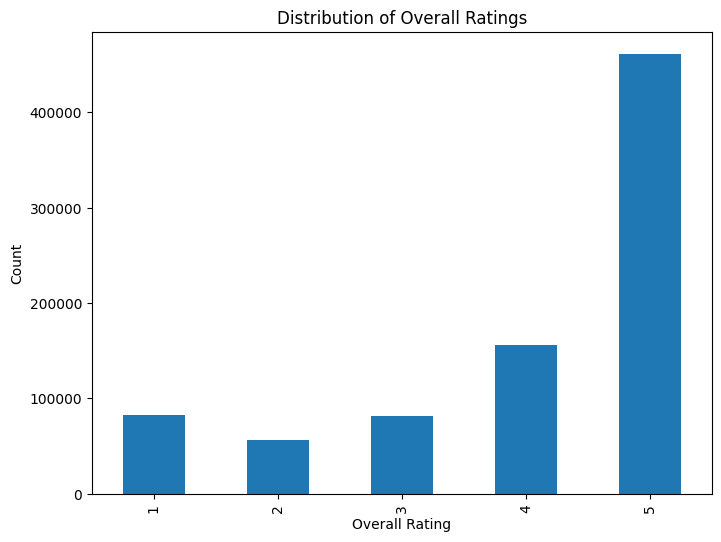

In [23]:
plt.figure(figsize=(8, 6))
train['overall'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Overall Ratings')
plt.xlabel('Overall Rating')
plt.ylabel('Count')
plt.show()

Adding some mathematical backbone to our implentation:

In [24]:
rating_distribution = train['overall'].value_counts().sort_index()
is_balanced = rating_distribution.min() / rating_distribution.max() >= 0.7
print("Is the dataset balanced?", is_balanced)

Is the dataset balanced? False


As it is shown, we need to handle the imbalancement.

We need to make sure that no overfitting is being made, so if we have got overfitting in our final results this is a checkpoint for sure!

We will use the IMBlearn random oversampler for the purpose:

In [25]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=78)
X_resampled, y_resampled = oversampler.fit_resample(train.drop(columns=["overall"]), train['overall'])

In [26]:
balanced_distribution = y_resampled.value_counts().sort_index()
print("Balanced Rating Distribution:")
print(balanced_distribution)

Balanced Rating Distribution:
overall
1    461305
2    461305
3    461305
4    461305
5    461305
Name: count, dtype: int64


After the imbalancement handling, we will go for positive, neutral, and negative wordclouds:

In [27]:
nltk.download('stopwords')
positive_reviews = train[train['overall'].isin([4, 5])]
neutral_reviews = train[train['overall'] == 3]
negative_reviews = train[train['overall'].isin([1, 2])]
positive_text = " ".join(positive_reviews['reviewText'])
neutral_text = " ".join(neutral_reviews['reviewText'])
negative_text = " ".join(negative_reviews['reviewText'])
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ROG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
wordcloud_positive = WordCloud(stopwords=stop_words, background_color='white').generate(positive_text)
wordcloud_neutral = WordCloud(stopwords=stop_words, background_color='white').generate(neutral_text)
wordcloud_negative = WordCloud(stopwords=stop_words, background_color='white').generate(negative_text)

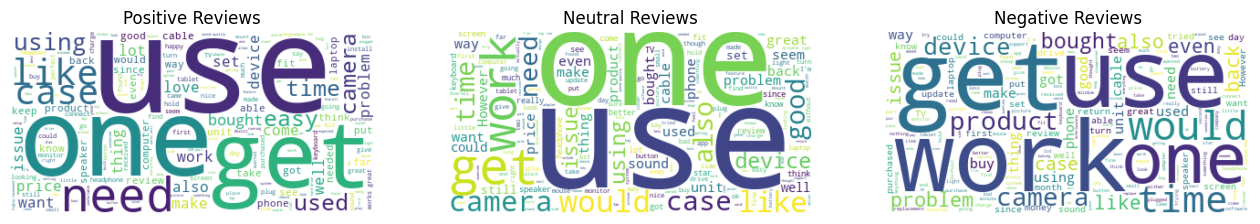

In [29]:
plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis("off")

plt.subplot(132)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Reviews')
plt.axis("off")

plt.subplot(133)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis("off")

plt.show()

Now we will find the top 10 useful users:

In [30]:
top_reviewers = train.groupby('reviewerID')['vote'].sum().reset_index()
top_reviewers = top_reviewers.sort_values(by='vote', ascending=False)
top_10_reviewers = top_reviewers.head(10)
top_10_reviewer_info = top_10_reviewers.merge(train[['reviewerID', 'reviewerName']], on='reviewerID')
top_10_reviewer_info = top_10_reviewer_info.drop_duplicates(subset='reviewerName')
print("Top 10 Reviewers with Most Votes:")
print(top_10_reviewer_info[['reviewerName', 'vote']])

Top 10 Reviewers with Most Votes:
          reviewerName    vote
0         Benson Leung  4572.0
29             Obi Wan  1608.0
58        Chris Winter  1352.0
62            Mayra S.  1342.0
81          VermontGuy  1337.0
88             Michael  1230.0
220      PhotoGraphics  1209.0
288           Nicholas  1188.0
311  NLee the Engineer  1103.0
342            David H  1045.0
